In [9]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [10]:
def import_history(file):
    with open(file, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        history = u.load()
        return history

In [11]:
history_baseline = import_history('history/baseline.p')
history_5x5 = import_history('history/model5x5.p')
history_binary = import_history('history/model_binary.p')
# history_13x13 = import_history('history/model13x13.p')
# history_20x20 = import_history('history/model20x20.p.p')

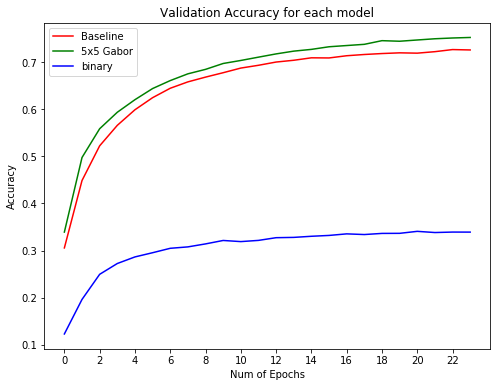

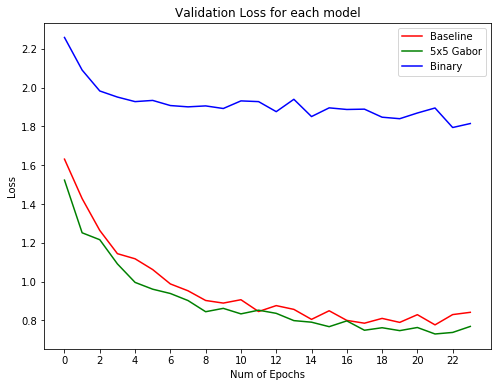

In [15]:
plt.figure(0)
epochs = 24
# plt.plot(history_13x13['acc'],'r')

plt.plot(history_baseline['acc'],'r')
plt.plot(history_5x5['acc'],'g')
plt.plot(history_binary['acc'],'b')

# plt.plot(history_13x13['acc'],'b')
# plt.plot(history_20x20['acc'],'k')

plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy for each model")
plt.legend(['Baseline', '5x5 Gabor', 'binary'])


plt.figure(1)
# plt.plot(history_13x13['loss'],'r')
plt.plot(history_baseline['val_loss'],'r')
plt.plot(history_5x5['val_loss'],'g')
plt.plot(history_binary['val_loss'],'b')

# plt.plot(history_13x13['val_loss'],'b')
# plt.plot(history_20x20['val_loss'],'k')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss for each model")
# plt.legend(['Baseline', '5x5 Gabor', '13x13 Gabor', '20x20 Gabor'])
plt.legend(['Baseline', '5x5 Gabor', 'Binary'])


plt.show()